In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time 
import csv
import os
from pprint import pprint
from pandas import json_normalize
import seaborn as sns; sns.set()

In [3]:
# import csv file that is a breakdown of cases and deaths per day by state and county
df = pd.read_csv("CSV Folder/us-counties.csv.txt")

#group by state and date so that data is no longer at the county level, but at the state level
state_df = df.groupby(["state","date"])

#Create a data frame that has total cases by date by state
cases = state_df["cases"].sum()
workable_df = pd.DataFrame(cases)
workable_df = workable_df.reset_index()

#get the data for deaths per state per day into a series format to add to the cases dataframe
deaths = state_df["deaths"].sum()
death=pd.DataFrame(deaths)
work_death=death.reset_index()
DEAD = work_death["deaths"]

# Add Deaths column to the cases dataframe
workable_df["Deaths"]=DEAD

#Create final dataframe with just the columns we are interested in
final_df = workable_df[["date","state","cases","Deaths"]]

#Sort final df by date and re-index
final_df = final_df.sort_values("date")
final_df = final_df.reset_index(drop = True)

In [4]:
#Liz's Hospital Dataframe



#read in .csv file
hospital_data = pd.read_csv("CSV Folder/hospitals.csv")

#set index to state_name
hospital_data.set_index("state_name",inplace=True)

#group dataframe by state_name
hg = hospital_data.groupby('state_name')

#do count of hg dataframe (where it groups by states)to get total count of hospitals, doctors, staff,
#icu beds, and icu beds utilized. Then add each series to new dataframe called 'state_hospital_data'

hg["num_icu_be"].count()
state_hospital_data = pd.DataFrame(hg["num_icu_be"].count())

hospitals = hg["hospital_n"].count()
state_hospital_data["Number of Hospitals"]=hospitals

doctors = hg["num_licens"].count()
state_hospital_data["Number of Doctors"]=doctors

staff = hg["num_staffe"].count()
state_hospital_data["Number of Staff"]=staff

icu_beds = hg["num_icu_be"].count()
state_hospital_data["ICU Beds Available"]=icu_beds

bed_utiliz = hg["bed_utiliz"].count()
state_hospital_data["ICU Beds Utilized"]=bed_utiliz

#drop double num_icu_be column
state_hospital_data.drop("num_icu_be",axis=1, inplace = True)



In [5]:
# reaching out to API to get current overall state data pertaining to cases, tests, hospitalizations, and deaths
url3 = "https://covidtracking.com/api/states"
response3 = requests.get(url3)
#Turned entire response into a dataframe
US_df = json_normalize(response3.json(), errors='ignore')
#Narrowed df to specific columns of interest 
US_df = US_df.iloc[:,[0,1,8,9,22,16,10,19]]

#Read in a State Name Abbrev CSV so that df's could be joined with different state naming conventions
st_abrev = pd.read_csv("CSV Folder/Covid Analysis Data - StateNameAbrev.csv")

# Replacing the state abbreviation with names for joining to other data
tests_df = st_abrev.merge(US_df, how = 'inner',left_on = "Abbreviation",right_on = "state")

#Droping abbreviation column since no other dataset used abbrev.
tests_df.drop(columns = ["Abbreviation","state"],inplace = True)

#Joined hospital information with the general information
comb1_df= tests_df.merge(state_hospital_data,how = 'inner',left_on = "State",right_on = "state_name")
#comb1_df.drop(columns = "state_name", inplace = True)

#Read in file about rankings of aggressive measures limiting the virus spread
States_Most_Aggressive_Measures_df = pd.read_csv("CSV Folder/States with the Most Aggressive Measures in Limiting Virus Exposure.csv", encoding ='latin-1')

#Joined rankings data
comb2_df = comb1_df.merge(States_Most_Aggressive_Measures_df, how = 'inner', on = 'State' )

#Renamed Column Headers
comb2_df.rename(columns = {"positive":"Positive",
                           "negative":"Negative",
                           "pending":"Pending",
                           "totalTestResults": "Total Tested",
                           "recovered": "Recovered",
                           "hospitalizedCurrently":"Currently Hospitalized",
                           "death": "Total Deaths",
                           "num_icu_be":"ICU Beds",
                           "Prevention & Containment Rank": "Prevention & Containment Rank",
                           "Risk Factors & Infrastructure Rank": "Risk Factors & Infrastructure Rank",
                           "Economic Impact Rank": "Economic Impact Rank"}, inplace = True)

In [6]:
comb2_df.head()

,State,Positive,Negative,Pending,Total Tested,Recovered,Currently Hospitalized,Total Deaths,Number of Hospitals,Number of Doctors,Number of Staff,ICU Beds Available,ICU Beds Utilized,Overall Rank,Prevention & Containment Rank,Risk Factors & Infrastructure Rank,Economic Impact Rank,Delta in Overall Rank vs. March 23
0,Alabama,5342,43295,NaN,48637,NaN,NaN,191.0,120,120,120,66,109,48,48,45,2,-15
1,Alaska,329,10790,NaN,11119,168.0,42.0,9.0,28,28,28,7,23,3,2,11,40,11
2,Arizona,5251,49901,NaN,55152,1215.0,669.0,208.0,126,126,126,46,108,39,36,46,19,-1
3,Arkansas,2262,26795,NaN,29057,849.0,86.0,43.0,106,106,106,40,100,46,45,49,5,1
4,California,33261,259645,7200.0,292906,NaN,4886.0,1268.0,466,466,466,302,401,18,15,44,16,-17


In [7]:
deathsbyState = comb2_df.loc[:,["State","Total Deaths"]]
deathsbyState.sort_values("Total Deaths", ascending = False,inplace = True)
deathsbyState["Percent of Deaths in US"]=round(deathsbyState["Total Deaths"]/deathsbyState["Total Deaths"].sum()*100,2)
deathsbyState.reset_index(drop = True)
USDeaths = deathsbyState["Total Deaths"].sum()
deathsbyStatePie = deathsbyState[deathsbyState["Percent of Deaths in US"]>1]
PercentTop = deathsbyStatePie["Percent of Deaths in US"].sum()
PercentOther = (100 - float(PercentTop))
OtherDeaths = USDeaths - deathsbyStatePie["Total Deaths"].sum()
print(deathsbyStatePie["Total Deaths"].sum())
print(OtherDeaths)
print(f" Total deaths in us is {USDeaths} and the percent of states with less than 1% is {PercentOther}")
Chart = deathsbyStatePie.append({"State":"Others","Total Deaths":OtherDeaths,"Percent of Deaths in US":PercentOther}, ignore_index = True)

36491.0
3455.0
 Total deaths in us is 39946.0 and the percent of states with less than 1% is 8.659999999999997


In [8]:
Chart

,State,Total Deaths,Percent of Deaths in US
0,New York,14828.0,37.12
1,New Jersey,4753.0,11.90
2,Michigan,2700.0,6.76
3,Massachusetts,1961.0,4.91
4,Pennsylvania,1564.0,3.92
5,Illinois,1468.0,3.67
6,Connecticut,1423.0,3.56
7,Louisiana,1405.0,3.52
8,California,1268.0,3.17
9,Florida,884.0,2.21


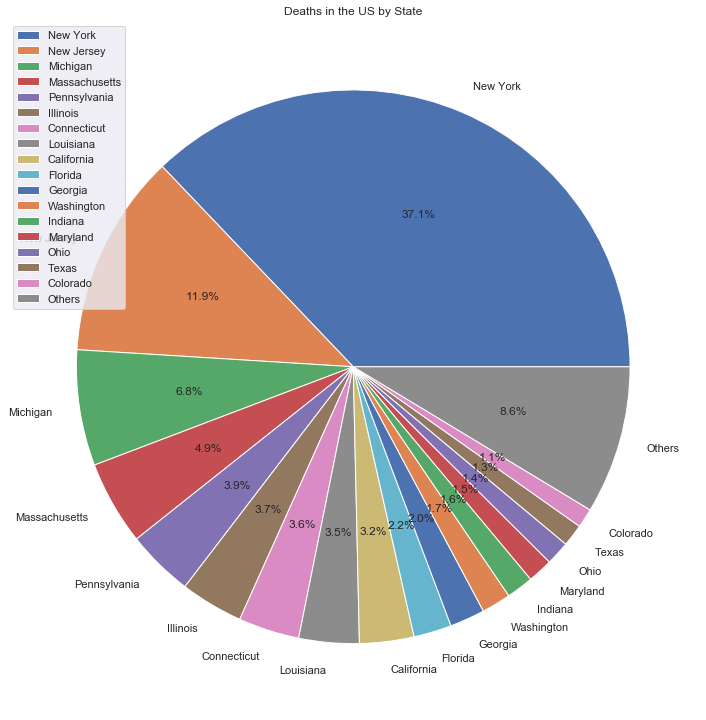

In [81]:
labels = Chart["State"]
sizes = Chart ["Total Deaths"]
fig1, ax1 = plt.subplots(figsize=(10, 10))
ax1.pie(sizes,labels = labels, autopct='%1.1f%%')
plt.tight_layout()
plt.title("Deaths in the US by State")
plt.legend( loc = 'upper left', )
plt.savefig("PNG Folder/DeathPie.png")

In [10]:
cases=final_df.pivot( index="date",columns="state",values = "cases")
cases = cases.fillna(0)

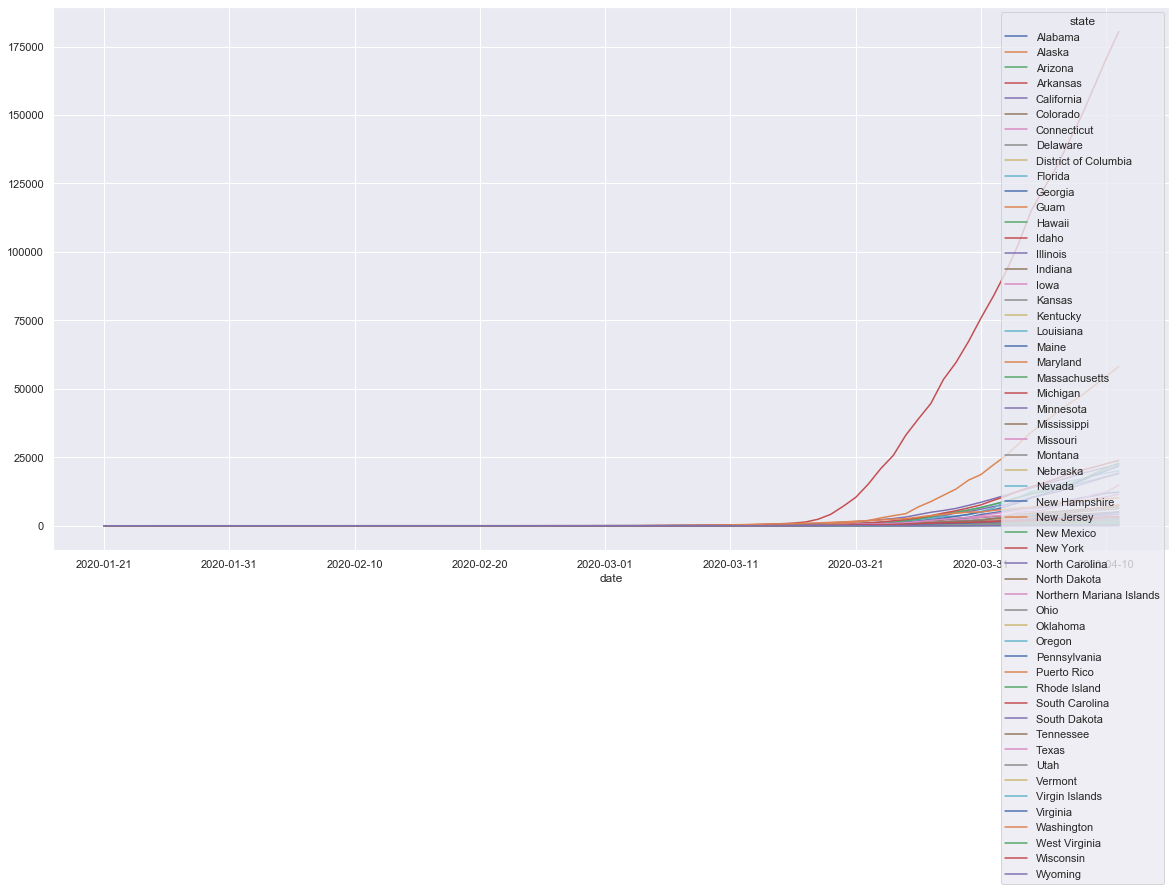

In [82]:

cases.plot.line(figsize = (20,10))
plt.show
plt.savefig("PNG Folder/CaseOverTime.png")

In [12]:
date_group = final_df.groupby("date")

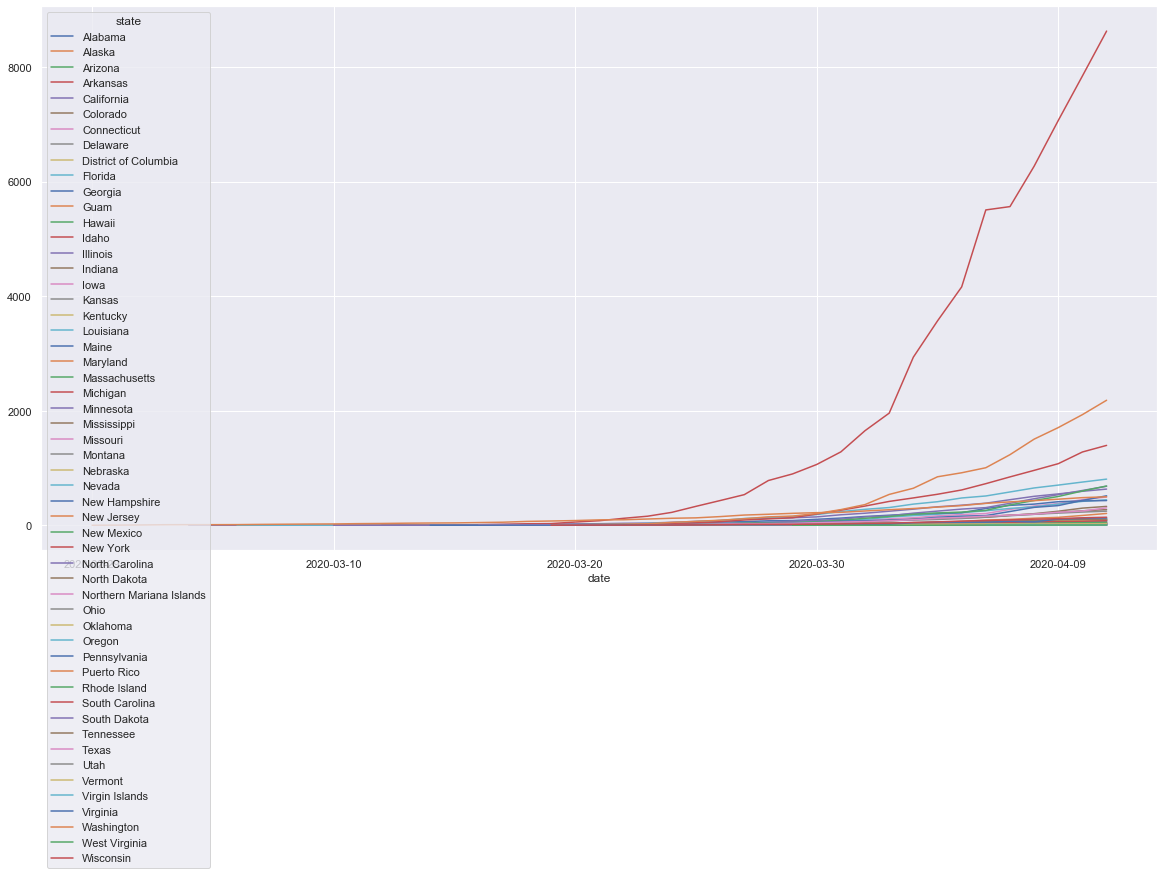

In [83]:
death_df = final_df[final_df["Deaths"]>0]
death_plot = death_df.pivot( index="date",columns="state",values = "Deaths")
death_plot.plot.line(figsize = (20,10))
plt.show
plt.savefig("PNG Folder/DeathsOverTime.png")

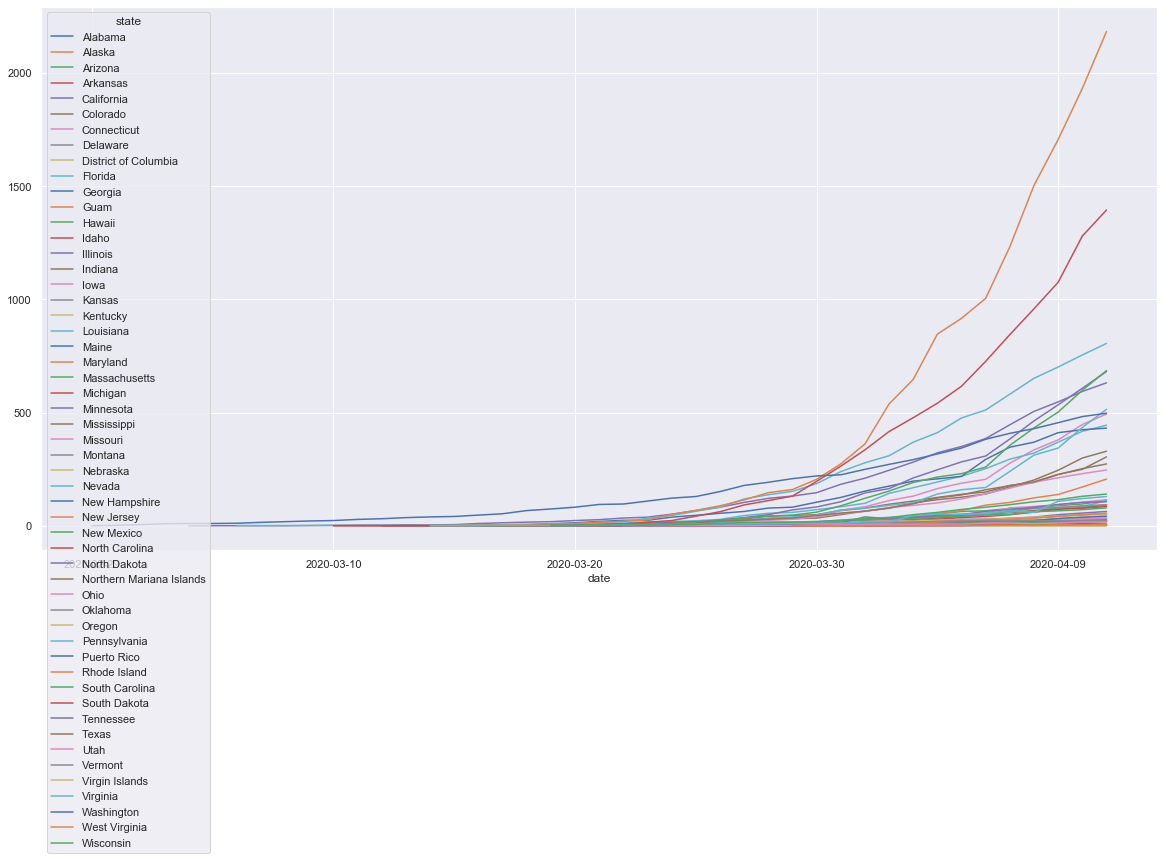

In [84]:
death_wo_NY = final_df[(final_df["Deaths"]>0) & (final_df["state"]!="New York")]
death_wo_NY = death_wo_NY.pivot( index="date",columns="state",values = "Deaths")
death_wo_NY.plot.line(figsize = (20,10))
plt.show
plt.savefig("PNG Folder/DeathsOverTimewoNY.png")

In [49]:
print(States_Most_Aggressive_Measures_df.head())
print(final_df.head())

   Overall Rank       State  Prevention & Containment Rank  \
0            48     Alabama                               48   
1             3      Alaska                                2   
2            39     Arizona                               36   
3            46    Arkansas                               45   
4            18  California                               15   

   Risk Factors & Infrastructure Rank  Economic Impact Rank  \
0                                    45                       2   
1                                    11                      40   
2                                    46                      19   
3                                    49                       5   
4                                    44                      16   

   Delta in Overall Rank vs. March 23  
0                                 -15  
1                                  11  
2                                  -1  
3                                   1  
4           

In [16]:
agg_time = pd.merge(final_df, States_Most_Aggressive_Measures_df, how = 'left', left_on = 'state', right_on = "State")
agg_time

,date,state,cases,Deaths,Overall Rank,State,Prevention & Containment Rank,Risk Factors & Infrastructure Rank,Economic Impact Rank,Delta in Overall Rank vs. March 23
0,2020-01-21,Washington,1,0,7.0,Washington,9.0,7.0,11.0,14.0
1,2020-01-22,Washington,1,0,7.0,Washington,9.0,7.0,11.0,14.0
2,2020-01-23,Washington,1,0,7.0,Washington,9.0,7.0,11.0,14.0
3,2020-01-24,Illinois,1,0,23.0,Illinois,25.0,16.0,48.0,-5.0
4,2020-01-24,Washington,1,0,7.0,Washington,9.0,7.0,11.0,14.0
...,...,...,...,...,...,...,...,...,...,...
2209,2020-04-11,New Mexico,1174,20,33.0,New Mexico,29.0,50.0,36.0,1.0
2210,2020-04-11,New York,180458,8627,1.0,New York,3.0,13.0,14.0,6.0
2211,2020-04-11,Georgia,12261,432,29.0,Georgia,30.0,40.0,4.0,12.0
2212,2020-04-11,Nebraska,729,18,49.0,Nebraska,49.0,20.0,8.0,-5.0


In [56]:
df = pd.read_csv("CSV Folder/Poverty by state 2018.csv")
df.rename( columns={'Unnamed: 0':'State'}, inplace=True )
df.head()
pop_df = pd.read_csv("CSV Folder/SCPRC-EST2019-18+POP-RES.csv")
pop_df= pop_df[["NAME", "POPESTIMATE2019","POPEST18PLUS2019","PCNT_POPEST18PLUS"]]
pop_df = pop_df.rename(columns = {"NAME": "State","POPESTIMATE2019":"2019 Pop Est","POPEST18PLUS2019":"2019 18+","PCNT_POPEST18PLUS":"Percent 18+"})
pop_df.head()
poverty_df = pop_df.merge(df,how = 'inner',on = "State")
print(poverty_df.head(2))
tests_df.head(2)

     State  2019 Pop Est  2019 18+  Percent 18+  Percent in Poverty (All)  \
0  Alabama       4903185   3814879         77.8                      16.8   
1   Alaska        731545    551562         75.4                      11.1   

   90% CI Lower  90%CI Upper  Children ages 0-17 in Poverty  90% CI Lower.1  \
0          16.5         17.1                           23.9            23.2   
1          10.5         11.7                           14.5            13.4   

   90%CI Upper.1  
0           24.6  
1           15.6  


,State,positive,negative,pending,totalTestResults,recovered,hospitalizedCurrently,death
0,Alabama,5342,43295,NaN,48637,NaN,NaN,191.0
1,Alaska,329,10790,NaN,11119,168.0,42.0,9.0


In [57]:
pov_death = tests_df.merge(poverty_df,how = 'inner', on = "State")
pov_death.head()

,State,positive,negative,pending,totalTestResults,recovered,hospitalizedCurrently,death,2019 Pop Est,2019 18+,Percent 18+,Percent in Poverty (All),90% CI Lower,90%CI Upper,Children ages 0-17 in Poverty,90% CI Lower.1,90%CI Upper.1
0,Alabama,5342,43295,NaN,48637,NaN,NaN,191.0,4903185,3814879,77.8,16.8,16.5,17.1,23.9,23.2,24.6
1,Alaska,329,10790,NaN,11119,168.0,42.0,9.0,731545,551562,75.4,11.1,10.5,11.7,14.5,13.4,15.6
2,Arizona,5251,49901,NaN,55152,1215.0,669.0,208.0,7278717,5638481,77.5,14.1,13.8,14.4,20.4,19.7,21.1
3,Arkansas,2262,26795,NaN,29057,849.0,86.0,43.0,3017804,2317649,76.8,16.8,16.3,17.3,23.8,22.8,24.8
4,California,33261,259645,7200.0,292906,NaN,4886.0,1268.0,39512223,30617582,77.5,12.8,12.7,12.9,17.4,17.1,17.7


In [58]:
pov_death.sort_values("Percent in Poverty (All)", ascending = False).head()
bins = (0,10,11,12,13,14,15,16,17,20)
labels = ("< 10","10-10.99","11-11.99","12-12.99","13-13.99","14-14.99","15-15.99","16-16.99","> 17")
pov_death["Poverty Groups"] = pd.cut(x = pov_death["Percent in Poverty (All)"], bins = bins, labels = labels)
pov_death

,State,positive,negative,pending,totalTestResults,recovered,hospitalizedCurrently,death,2019 Pop Est,2019 18+,Percent 18+,Percent in Poverty (All),90% CI Lower,90%CI Upper,Children ages 0-17 in Poverty,90% CI Lower.1,90%CI Upper.1,Poverty Groups
0,Alabama,5342,43295,NaN,48637,NaN,NaN,191.0,4903185,3814879,77.8,16.8,16.5,17.1,23.9,23.2,24.6,16-16.99
1,Alaska,329,10790,NaN,11119,168.0,42.0,9.0,731545,551562,75.4,11.1,10.5,11.7,14.5,13.4,15.6,11-11.99
2,Arizona,5251,49901,NaN,55152,1215.0,669.0,208.0,7278717,5638481,77.5,14.1,13.8,14.4,20.4,19.7,21.1,14-14.99
3,Arkansas,2262,26795,NaN,29057,849.0,86.0,43.0,3017804,2317649,76.8,16.8,16.3,17.3,23.8,22.8,24.8,16-16.99
4,California,33261,259645,7200.0,292906,NaN,4886.0,1268.0,39512223,30617582,77.5,12.8,12.7,12.9,17.4,17.1,17.7,12-12.99
5,Colorado,10106,37360,NaN,47466,NaN,861.0,449.0,5758736,4499217,78.1,9.7,9.5,9.9,12.1,11.4,12.8,< 10
6,Connecticut,20360,43832,NaN,64192,NaN,1949.0,1423.0,3565287,2837847,79.6,10.3,10.0,10.6,13.8,13.1,14.5,10-10.99
7,Delaware,2931,13725,NaN,16656,565.0,263.0,82.0,973764,770192,79.1,12.2,11.6,12.8,17.6,16.4,18.8,12-12.99
8,Florida,27869,254471,1264.0,282340,NaN,NaN,884.0,21477737,17247808,80.3,13.7,13.5,13.9,20.0,19.5,20.5,13-13.99
9,Georgia,20166,68259,NaN,88425,NaN,NaN,818.0,10617423,8113542,76.4,14.5,14.2,14.8,21.0,20.4,21.6,14-14.99


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


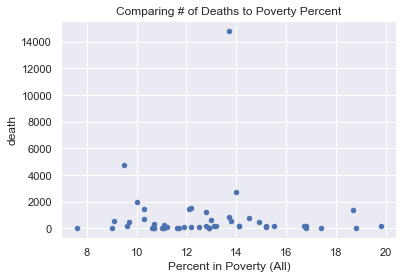

In [86]:
pov_death.plot.scatter("Percent in Poverty (All)","death")
plt.title("Comparing # of Deaths to Poverty Percent")
plt.savefig("PNG Folder/PovertyVsDeaths.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


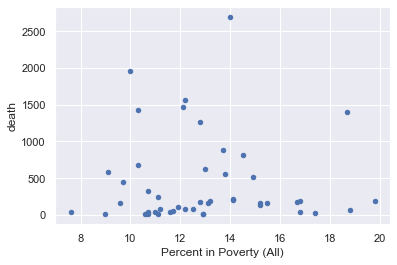

In [23]:
pov_wo_NY = pov_death[(pov_death["State"] != "New York")&(pov_death["State"] !="New Jersey")]
pov_wo_NY.plot.scatter("Percent in Poverty (All)","death")

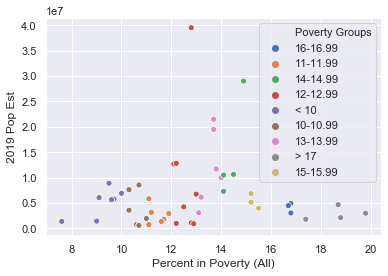

In [39]:
ax= sns.scatterplot(x="Percent in Poverty (All)", y ="2019 Pop Est",hue = "Poverty Groups",data= pov_death)

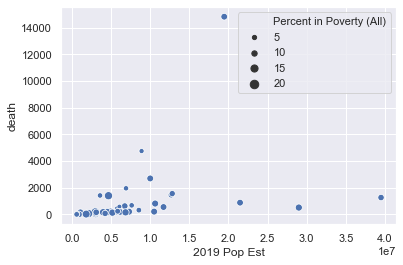

In [44]:
ax= sns.scatterplot(x="2019 Pop Est", y ="death",size = "Percent in Poverty (All)",data= pov_death)

In [59]:
grades = pd.read_csv("CSV Folder/StayatHomeGrades.txt")
grades.head()
pov_death = pov_death.merge(grades, how = 'inner', on = "State" )
#pov_death.drop(columns = ["Grade_x","Grade_y"], inplace = True)

In [71]:
grade = pov_death.sort_values("Grade", ascending = False)
grade

,State,positive,negative,pending,totalTestResults,recovered,hospitalizedCurrently,death,2019 Pop Est,2019 18+,...,Percent in Poverty (All),90% CI Lower,90%CI Upper,Children ages 0-17 in Poverty,90% CI Lower.1,90%CI Upper.1,Poverty Groups,Grade,Date Announced,Effective Date
24,Missouri,5941,52019,NaN,57960,NaN,1001.0,189.0,6137428,4766843,...,13.2,12.9,13.5,18.3,17.6,19.0,13-13.99,D+,April 3,April 6
13,Indiana,12097,55167,NaN,67264,NaN,NaN,630.0,6732219,5164245,...,13.0,12.7,13.3,17.5,16.8,18.2,12-12.99,D+,March 23,March 24
46,West Virginia,939,24897,NaN,25836,330.0,85.0,27.0,1792147,1432580,...,17.4,16.9,17.9,23.2,22.1,24.3,> 17,D+,March 23,March 24
44,Virginia,9451,48903,477.0,58354,1418.0,1331.0,324.0,8535519,6674671,...,10.7,10.5,10.9,13.8,13.2,14.4,10-10.99,D+,March 30,March 30
41,Tennessee,7394,100788,NaN,108182,3828.0,NaN,157.0,6829174,5319123,...,15.2,14.9,15.5,21.8,21.1,22.5,15-15.99,D+,March 30,March 31
39,South Carolina,4608,37833,NaN,42441,3317.0,NaN,135.0,5148714,4037531,...,15.2,14.9,15.5,22.1,21.3,22.9,15-15.99,D+,April 6,April 7
38,Rhode Island,5500,33833,NaN,39333,315.0,271.0,171.0,1059361,854866,...,12.8,12.2,13.4,18.0,16.8,19.2,12-12.99,D+,March 28,March 28
34,Ohio,13725,80989,NaN,94714,NaN,NaN,557.0,11689100,9111081,...,13.8,13.6,14.0,19.2,18.6,19.8,13-13.99,D+,March 22,March 23
32,North Carolina,6951,76380,NaN,83331,NaN,427.0,213.0,10488084,8187369,...,14.1,13.8,14.4,20.2,19.6,20.8,14-14.99,D+,March 27,March 30
26,Nebraska,1722,14957,NaN,16679,NaN,NaN,38.0,1934408,1458334,...,11.0,10.6,11.4,12.9,12.1,13.7,10-10.99,D+,–,–


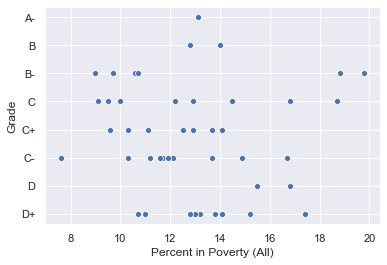

In [72]:
ax= sns.scatterplot(x="Percent in Poverty (All)", y ="Grade",data= grade )

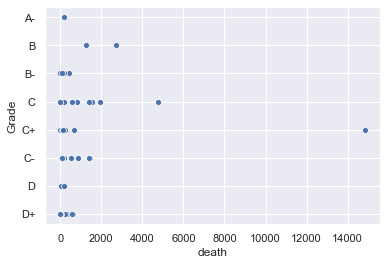

In [73]:
ax= sns.scatterplot(x="death", y ="Grade",data= grade)

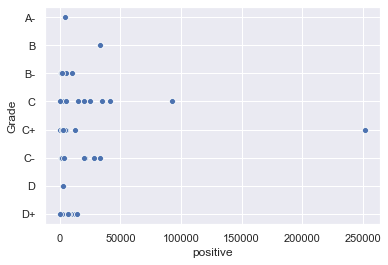

In [74]:
ax= sns.scatterplot(x="positive", y ="Grade",data= grade)

In [75]:
avg_grade = grade.groupby("Grade")

In [76]:
avg_grade["death"].mean()

Grade
A-     163.000000
B     1984.000000
B-     127.000000
C     1263.333333
C+    2026.875000
C-     478.200000
D      103.500000
D+     222.454545
Name: death, dtype: float64

In [80]:
avg_grade["positive"].mean()

Grade
A-     3937.000000
B     33114.000000
B-     3156.333333
C     26291.000000
C+    35062.000000
C-    11448.700000
D      2534.500000
D+     6240.909091
Name: positive, dtype: float64